In [ ]:
# Adapted from:
#\https://www.analyticsvidhya.com/blog/2020/07/transfer-learning-for-nlp-fine-tuning-bert-for-text-classification/
#https://www.programmersought.com/article/31037125394/

In [1]:
pip install transformers

     |████████████████████████████████| 2.1MB 15.1MB/s 
     |████████████████████████████████| 3.3MB 58.2MB/s 
     |████████████████████████████████| 901kB 57.4MB/s 


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
import pandas as pd
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import time
from sklearn.metrics import classification_report
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# specify GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#df_all = pd.read_csv('Tweets.csv')
df_all = pd.read_csv('/content/drive/My Drive/content/Tweets.csv', encoding = 'latin-1' )

In [5]:
df_all.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24/2/2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24/2/2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24/2/2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24/2/2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24/2/2015 11:14,NaN,Pacific Time (US & Canada)


In [6]:
df_all = df_all[['text','airline_sentiment']]
dic = {'negative' : 0, 'neutral': 1, 'positive': 2}
df_all['airline_sentiment']= df_all['airline_sentiment'].replace(dic).astype('int64')
df_all.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,1
1,@VirginAmerica plus you've added commercials t...,2
2,@VirginAmerica I didn't today... Must mean I n...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0


In [7]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(df_all['text'], df_all['airline_sentiment'], 
                                                                    random_state=45, 
                                                                    test_size=0.3, 
                                                                    stratify=df_all['airline_sentiment'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=45, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [8]:
from transformers import AutoModel, BertTokenizerFast
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [9]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

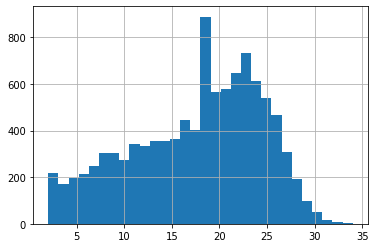

In [10]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 30)

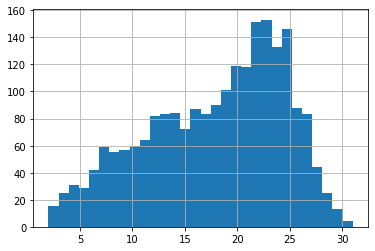

In [11]:
# get length of all the messages in the val set
seq_len = [len(i.split()) for i in val_text]
pd.Series(seq_len).hist(bins = 30)

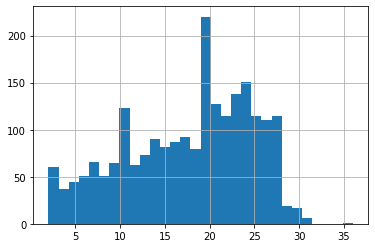

In [12]:
# get length of all the messages in the test set
seq_len = [len(i.split()) for i in test_text]
pd.Series(seq_len).hist(bins = 30)

In [13]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 25,
    padding='longest',
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    padding='longest',
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    padding='longest',
    truncation=True
)

In [14]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [15]:
#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size, drop_last=True)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size, drop_last=True)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size, drop_last=True)

In [16]:
#print('train loader',len(train_dataloader.dataset))
#print('val loader',len(val_dataloader.dataset))
#print('test loader',len(test_loader))

In [17]:
#import torch.nn as nn
#import torch.nn.functional as F
from torch.autograd import Variable


class AttnDPCNN(nn.Module):

    def __init__(self, batch_size,seq_len,embedding_dim,output_size_linear, 
                 cnn_channel_size, cnn_kernel_size=(3,1),cnn_padding=0, cnn_stride=1, attn_nodes_per_layer = 10):

        super(AttnDPCNN, self).__init__()
        #self.bert=bert
        self.attn_nodes_per_layer = attn_nodes_per_layer
        self.channel_size = cnn_channel_size
        self.output_size_linear = output_size_linear
        self.cnn_kernel_size = cnn_kernel_size
        self.padding = cnn_padding
        self.stride = cnn_stride
        #self.vocab_size = vocab_size
        self.embed_dim = embedding_dim
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.maps = {}
        self.get_maps = False
        
        self.collect_out_softmax = torch.zeros(1,1).to(device)
        self.collect_out_attn = torch.zeros(self.batch_size,self.attn_nodes_per_layer).to(device)
        
        #self.embed = nn.Embedding(self.vocab_size, self.embed_dim)
        self.conv1 = nn.Conv2d(1,  self.channel_size, (3,self.embed_dim), stride = 1) # embed_dim becomes 1
        self.conv2 = nn.Conv2d(self.channel_size,  self.channel_size,  
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride)
        self.padding1 = nn.ZeroPad2d((0, 0, 1, 1))  # top bottom
        self.padding2 = nn.ZeroPad2d((0, 0, 0, 1))  # bottom
        self.max_pool = nn.MaxPool2d(kernel_size=(3, 1), stride=2)      
        
        self._repeat_block = nn.Sequential( # input [batch_size, num_filters, seq_len-3+1, 1]
                    nn.ZeroPad2d((0, 0, 1, 1)), # [batch_size, num_filters, seq_len, 1]
                    nn.ReLU(),
                    nn.Conv2d(self.channel_size,  self.channel_size,   # [batch_size, num_filters, seq_len-3+1, 1]
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride),
                    nn.ZeroPad2d((0, 0, 1, 1)), # [batch_size, num_filters, seq_len, 1]
                    nn.ReLU(),
                    nn.Conv2d(self.channel_size,  self.channel_size,  # [batch_size, num_filters, seq_len-3+1, 1]
                                kernel_size=self.cnn_kernel_size, padding=0,
                               stride = self.stride),
            )
        
        
        # To get variying attention weights for 1) softmax output 2) 10 representing features
        self.num_repeat_blocks, self.size_repeat_blocks_list = self.dividible(2)
        # self.weight_softmax_list, self.weight_attn_list = self.getWeights_init()
        
        self.counter=0
        
        # Drop probability
        self.dropout = nn.Dropout(p=0.2)
        # Last linear layer (FC)
        #self.linear1 = nn.Linear(self.num_repeat_blocks*self.attn_nodes_per_layer,self.output_size_linear)
        self.linear1 = nn.Linear(self.channel_size,self.output_size_linear)
          
    def repeat_block(self, x): # input [batch_size, num_filters, seq_len-3+1, 1]
        x = self.padding2(x) # [batch_size, num_filters, seq_len-1, 1] -> seq_len-3+1+1 = seq_len-1
        #print('padding')
        x1 = self.max_pool(x)  # [batch_size, num_filters, (seq_len-1) // 3, 1 //1] -> seq_len-3+1+1 = seq_len-1
        #print('x1',x1.shape)
        # conv block
        x2 = self._repeat_block(x1)
        #print('x2',x2.shape)
        # Identity addition
        #x = x1 + x2
        #print('x1+x2',x.shape)
        return x1,x2

    def forward(self, x):
        
        self.counter =0

        #embed = self.bert(sent_id, attention_mask=mask)
        #x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
        x = self.conv1(x)  # [batch_size, num_filters, seq_len-3+1, 1]
        #print(x.shape)
        x = self.padding1(x)  # [batch_size, num_filters, seq_len, 1]
        x = F.relu(x)
        x = self.conv2(x)  # [batch_size, num_filters, seq_len-3+1, 1]

        count=0
        while x.shape[2] >= 2: # till seq_len is 1
            #print("start x",x.shape)
            x_prev,x = self.repeat_block(x)  # [batch_size, num_filters,1,1] at the end
            x = x+x_prev
            #print("after pooling x",x.shape)
            seq = x.shape[2]

            ## DOT PRODUCT SELF ATTENTION
            query = x.clone().squeeze() # 32 x feature map x seq
            #print("query",query.shape)
            key = x.clone().squeeze() # 32 x feature map x seq
            #print("key",query.shape)
            value = x.clone().squeeze() # 32 x feature map x seq
            #print("value",value.shape)

            if len(query.shape) ==2:
              query = query.unsqueeze(2)
            if len(key.shape) ==2:
              key = key.unsqueeze(2)
            if len(value.shape) ==2:
              value = value.unsqueeze(2)

            # dot product
            dot_prod = torch.bmm(query.transpose(1,2),key)  # 32 x seq x seq
            #print("dp1",dot_prod[0,0,:])
            dot_prod = dot_prod / query.shape[2] # 32 x seq x seq
            #print("dot product", dot_prod.shape)

            softmax_out = torch.softmax(dot_prod, dim=1)
            #print(softmax_out[0,:,0].sum()) #== 1
            x = torch.bmm(value,softmax_out.transpose(1,2))

            x = x.reshape(self.batch_size, self.channel_size, seq).unsqueeze(3)
            
            #print("end x", x.shape)
            #break
            if self.get_maps:
              self.maps.update({count : softmax_out})
            count+=1

        ## FULLY CONNECTED ##
        # linear layer
        # output = final_collect_out_attn.reshape(x.shape[0], -1) # [batch_size, num_filters]
        output = x.reshape(x.shape[0], -1) # [batch_size, num_filters]
        # x = x.squeeze()  # [batch_size, num_filters]
        output = self.linear1(output)  # [batch_size, output size]
        output = self.dropout(output)
        return output
    
    def dividible(self,p):
        n=self.seq_len
        i = 0
        out=[]
        while n>=p:
            if i==0:
                n = (n-2)//2
               #n=n-2
               #out.append(n-1)
            else:
                n = n//2
                #out.append(n)
            i += 1
            out.append(n)
        return i,out
    
    def getWeights_init(self):
        weights_softmax_list = []
        weights_attn_list = []
        for i in range(self.num_repeat_blocks):
            # size_repeat_blocks_list contains various seq length
            #print('batch size', self.batch_size)
            #print('seq len', self.size_repeat_blocks_list[i])
            #print('channel size', self.channel_size)
            weights_softmax_list.append(Variable(torch.randn(1,self.batch_size*1*self.size_repeat_blocks_list[i]*self.channel_size)).to(device))
            weights_attn_list.append(Variable(torch.randn(self.attn_nodes_per_layer,1*self.size_repeat_blocks_list[i]*self.channel_size)).to(device)) # fix output features as 10
        return weights_softmax_list,weights_attn_list
            

In [18]:
dpcnn = AttnDPCNN(32,40,768, 3, 64) # batchsize, seq len, embed dim, classes, no of filters
dpcnn = dpcnn.to(device)
bert = bert.to(device)

In [19]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
#optimizer_bert = AdamW(bert.parameters(), lr = 1e-5)          # lr=learning rate
optimizer_dpcnn = AdamW(dpcnn.parameters(), lr = 0.001)
#scheduler_bert = torch.optim.lr_scheduler.StepLR(optimizer_bert, step_size = 2, gamma=0.8)
scheduler_dpcnn = torch.optim.lr_scheduler.StepLR(optimizer_dpcnn, step_size = 2, gamma=0.3)

In [20]:

from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.53167315 1.57491932 2.06529625]


In [21]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.CrossEntropyLoss(weight=weights) 

# number of training epochs
epochs = 20

In [22]:
# function to train the model
def train():
  
  bert.train()
  dpcnn.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    if step == len(train_dataloader)-1:
      dpcnn.get_maps=True
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 

    #optimizer_bert.zero_grad()
    optimizer_dpcnn.zero_grad()   

    # get model predictions for the current batch
    
    embed = bert(sent_id, attention_mask=mask)
    x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
    preds = dpcnn(x)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    #torch.nn.utils.clip_grad_norm_(bert.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(dpcnn.parameters(), 1.0)
  
    # update parameters
    #optimizer_bert.step()
    optimizer_dpcnn.step() 

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)
    
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [23]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  t0 = time.time()
  # deactivate dropout layers
  #model.eval() replace below?
  bert.eval()
  dpcnn.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = time.time() - t0
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      embed = bert(sent_id, attention_mask=mask)
      x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
      preds = dpcnn(x)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [24]:
#print(model.num_repeat_blocks)
#print(model.size_repeat_blocks_list)

In [25]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]


#for each epoch
for epoch in range(1, epochs+1):

    print('\n Epoch {:} / {:}'.format(epoch, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()

    #scheduler_bert.step()
    scheduler_dpcnn.step()
    
    #save the best model
    #if valid_loss < best_valid_loss:
    #    best_valid_loss = valid_loss
    #    torch.save(bert.state_dict(), 'bert_saved_weights.pt')
    #    torch.save(dpcnn.state_dict(), 'dpcnn_saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
  
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    #break


 Epoch 1 / 20
  Batch    50  of    320.
  Batch   100  of    320.
  Batch   150  of    320.
  Batch   200  of    320.
  Batch   250  of    320.
  Batch   300  of    320.

Evaluating...
  Batch    50  of     68.

Training Loss: 0.767
Validation Loss: 0.596

 Epoch 2 / 20
  Batch    50  of    320.
  Batch   100  of    320.
  Batch   150  of    320.
  Batch   200  of    320.
  Batch   250  of    320.
  Batch   300  of    320.

Evaluating...
  Batch    50  of     68.

Training Loss: 0.650
Validation Loss: 0.574

 Epoch 3 / 20
  Batch    50  of    320.
  Batch   100  of    320.
  Batch   150  of    320.
  Batch   200  of    320.
  Batch   250  of    320.
  Batch   300  of    320.

Evaluating...
  Batch    50  of     68.

Training Loss: 0.580
Validation Loss: 0.564

 Epoch 4 / 20
  Batch    50  of    320.
  Batch   100  of    320.
  Batch   150  of    320.
  Batch   200  of    320.
  Batch   250  of    320.
  Batch   300  of    320.

Evaluating...
  Batch    50  of     68.

Training Loss: 0

TEST

In [26]:
# function for evaluating the model
def test():
  
  print("\nEvaluating...")
  t0 = time.time()
  # deactivate dropout layers
  #model.eval() replace below?

  #load weights of best model
  #bpath = 'bert_saved_weights.pt'
  #bert.load_state_dict(bert.load(bpath))

  bert.eval()
  dpcnn.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []
  total_targets = []
  # iterate over batches
  for step,batch in enumerate(test_dataloader):
    if step == len(test_dataloader)-1:
      dpcnn.get_maps=True 
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = time.time() - t0
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      embed = bert(sent_id, attention_mask=mask)
      x = embed['last_hidden_state'].unsqueeze(1) # [batch_size, 1, seq_len, embedding_dim]
      preds = dpcnn(x)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu()
      labels = labels.detach().cpu()

      total_preds.append(preds.numpy())
      total_targets.append(labels.numpy())
  # compute the validation loss of the epoch
  avg_loss = total_loss / len(test_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  total_targets = np.concatenate(total_targets, axis=0)

  return avg_loss, total_preds, total_targets

In [27]:
#load weights of best model
#bpath = 'bert_saved_weights.pt'
#bert.load_state_dict(bert.load(bpath))
#load weights of best model
#dpath = 'dpcnn_saved_weights.pt'
#dpcnn.load_state_dict(dpcnn.load(dpath))

In [28]:
test_loss, test_preds, test_targets = test()
print(f'Test Loss: {test_loss:.3f}')


Evaluating...
  Batch    50  of     68.
Test Loss: 0.586


In [29]:
test_preds_classes = np.argmax(test_preds, axis = 1)
print(classification_report(test_targets, test_preds_classes))

              precision    recall  f1-score   support

           0       0.93      0.79      0.85      1368
           1       0.54      0.71      0.62       457
           2       0.69      0.81      0.75       351

    accuracy                           0.78      2176
   macro avg       0.72      0.77      0.74      2176
weighted avg       0.81      0.78      0.79      2176



In [30]:
# Get confusion matrix
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(test_targets, test_preds_classes)
cf #cf[actu][pred]
# pred 0 1 2 3
# actu
# 0
# 1
# 2
# 3

array([[1079,  228,   61],
       [  64,  325,   68],
       [  20,   45,  286]])

In [31]:
import matplotlib.pyplot as plt # we only need pyplot
import matplotlib.cm as cm
import matplotlib

# Get components of actual labels
def getPredictionOfActualLabels(cf,actual_label,angle=45):
    sizes = []
    # cf[actual-1][predicted-1]
    #pa1 = cf[actual_label-1][0]
    #pa2 = cf[actual_label-1][1]
    #pa3 = cf[actual_label-1][2]
    #pa4 = cf[actual_label-1][3]
    #pa5 = cf[actual_label-1][4]
    
    for i in range(3):
        sizes.append(cf[actual_label][i])
    
    # Data to plot
    labels = ['negative', 'neutral', 'positive']
    #sizes = [p[0], p[1], p[2], p[3]]
    colors = ['lightskyblue', 'yellowgreen', 'lightcoral']

    # Plot
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', shadow=False, startangle=angle, textprops={'fontsize': 14})
    plt.title("Predictions of Ratings with actual labels as "+labels[actual_label],fontsize=20)
    #matplotlib.rcParams['text.color'] = 'white'

    plt.axis('equal')
    plt.show()


  # Get components of predictions
def getActualLabelsOfPredictions(cf,pred_label,angle=45):
    sizes = []
    # cf[actual-1][predicted-1]
    #pa1 = cf[actual_label-1][0]
    #pa2 = cf[actual_label-1][1]
    #pa3 = cf[actual_label-1][2]
    #pa4 = cf[actual_label-1][3]
    #pa5 = cf[actual_label-1][4]
    
    for i in range(3):
        sizes.append(cf[i][pred_label])
    
    # Data to plot
    labels = ['negative', 'neutral', 'positive']
    #sizes = [p[0], p[1], p[2], p[3]]
    colors = ['lightskyblue', 'yellowgreen', 'lightcoral']

    # Plot
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.0f%%', shadow=False, startangle=angle, textprops={'fontsize': 14})
    plt.title("Actual Labels of Ratings predicted as "+labels[pred_label],fontsize=20)
    #matplotlib.rcParams['text.color'] = 'white'

    plt.axis('equal')
    plt.show()

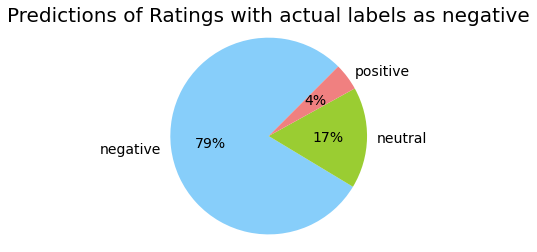

In [32]:
getPredictionOfActualLabels(cf,0,angle=45)


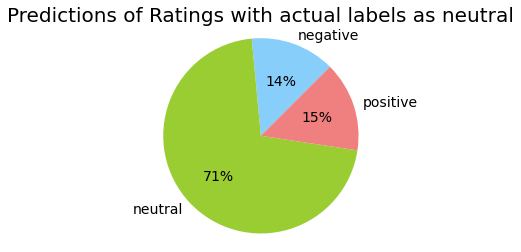

In [33]:
getPredictionOfActualLabels(cf,1,angle=45)

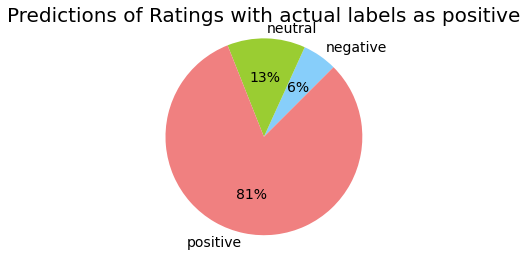

In [34]:
getPredictionOfActualLabels(cf,2,angle=45)

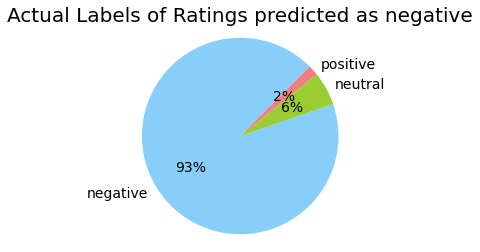

In [35]:
getActualLabelsOfPredictions(cf,0,angle=45)

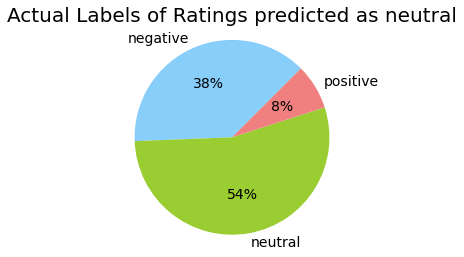

In [36]:
getActualLabelsOfPredictions(cf,1,angle=45)

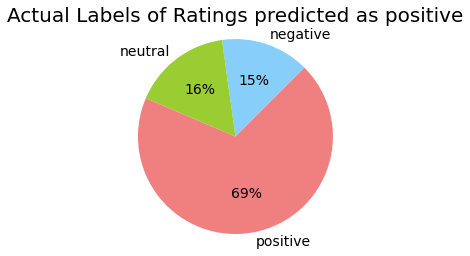

In [37]:
getActualLabelsOfPredictions(cf,2,angle=45)

In [38]:
import pickle

filenamedpcnn = '/content/drive/My Drive/content/BertAttnsDPCNN_selfattention_False_Tweet_Exp3dpcnn.pkl'
filenamebert = '/content/drive/My Drive/content/BertAttnsDPCNN_selfattention_False_Tweet_Exp3bert.pkl'
pickle.dump(bert, open(filenamebert, 'wb'))
pickle.dump(dpcnn, open(filenamedpcnn, 'wb'))

In [39]:
map = dpcnn.maps[0]
map.shape

torch.Size([32, 11, 11])